In [1]:
from google.colab import drive 
drive.mount('/content/gdrive') 
!ls -la "/content/gdrive/My Drive/colab_data"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
total 4
drwx------ 3 root root 4096 Jul 15 11:00 models


In [65]:
%cd "/content/gdrive/My Drive/colab_data/models/research/"

/content/gdrive/My Drive/colab_data/models/research


In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
sys.path.append("..")
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import dataset_util
%matplotlib inline

In [0]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('object_detection', 'data', 'mscoco_label_map.pbtxt')

In [0]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [7]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

W0726 12:30:03.241920 140445203502976 deprecation_wrapper.py:119] From /content/gdrive/My Drive/colab_data/models/research/object_detection/utils/label_map_util.py:132: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.



In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

Detection


In [9]:
PATH_TO_TEST_IMAGES_DIR = os.path.join('object_detection', 'brand-logo-detection-dataset', 'test_jpg')
IMAGES = ['193668.jpg']
#TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]
TEST_IMAGE_PATHS = [os.path.join(PATH_TO_TEST_IMAGES_DIR, image) for image in IMAGES]
# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)
print(TEST_IMAGE_PATHS)


['object_detection/brand-logo-detection-dataset/test_jpg/193668.jpg']


In [0]:
with open(os.path.join('object_detection', 'brand-logo-detection-dataset', 'trainval_bboxes.txt'), "r") as f:
    markup = defaultdict(list)
    for line in f:   
        line = line.strip()
        data = line.split(',')
        #print(data)
        img_name = data[0]
        img_markup = {
            "class": data[1],
            "rect": {
                "x": data[2],
                "y": data[3],
                "width": data[4],
                "height": data[5]
            }
        }
        markup[img_name].append(img_markup)
        

In [11]:
list(markup.keys())[:10]

['2325670467.jpg',
 '2359495755.jpg',
 '2727802511.jpg',
 '321106127.jpg',
 '343855903.jpg',
 '343862498.jpg',
 '4485663646.jpg',
 '4946956773.jpg',
 '4947816272.jpg',
 '500095568.jpg']

In [19]:
list(markup.values())[:10]

[[{'class': 'google',
   'rect': {'height': '342', 'width': '892', 'x': '51', 'y': '198'}}],
 [{'class': 'google',
   'rect': {'height': '327', 'width': '948', 'x': '73', 'y': '228'}}],
 [{'class': 'google',
   'rect': {'height': '311', 'width': '854', 'x': '68', 'y': '72'}}],
 [{'class': 'google',
   'rect': {'height': '203', 'width': '519', 'x': '461', 'y': '354'}}],
 [{'class': 'google',
   'rect': {'height': '413', 'width': '686', 'x': '176', 'y': '104'}}],
 [{'class': 'google',
   'rect': {'height': '330', 'width': '729', 'x': '132', 'y': '73'}}],
 [{'class': 'google',
   'rect': {'height': '360', 'width': '992', 'x': '2', 'y': '40'}}],
 [{'class': 'google',
   'rect': {'height': '383', 'width': '1004', 'x': '2', 'y': '26'}}],
 [{'class': 'google',
   'rect': {'height': '366', 'width': '998', 'x': '25', 'y': '76'}}],
 [{'class': 'google',
   'rect': {'height': '375', 'width': '985', 'x': '11', 'y': '25'}}]]

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

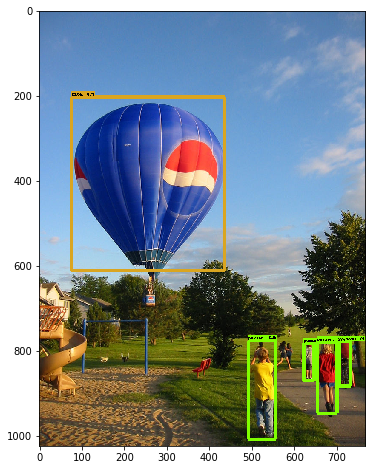

In [13]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

In [66]:
fpath = os.path.join('object_detection', 'brand-logo-detection-dataset', 'logo_label_map.pbtxt')
with open(fpath, 'r') as f:
  d = f.readlines()
  d = [r.strip() for r in d if r.strip() and '{' not in r and '}' not in r and 'item' not in r]
  names_to_ids = {d[i+1].split(':')[1].strip().replace("'", ""): int(d[i].split(':')[1].strip()) for i in range(0, len(d), 2)}
  ids_to_names = {val: key for key, val in names_to_ids.items()}

  print('names_to_ids', names_to_ids)
  print('ids_to_names', ids_to_names)

names_to_ids {'dhl': 1, 'hp': 2, 'aldi': 3, 'cocacola': 4, 'ups': 5, 'nvidia': 6, 'singha': 7, 'corona': 8, 'milka': 9, 'chimay': 10, 'guiness': 11, 'fedex': 12, 'tsingtao': 13, 'starbucks': 14, 'esso': 15, 'fosters': 16, 'pepsi': 17, 'paulaner': 18, 'ford': 19, 'texaco': 20, 'bmw': 21, 'erdinger': 22, 'ferrari': 23, 'adidas': 24, 'rittersport': 25, 'shell': 26, 'heineken': 27, 'carlsberg': 28, 'google': 29, 'apple': 30, 'becks': 31, 'stellaartois': 32}
ids_to_names {1: 'dhl', 2: 'hp', 3: 'aldi', 4: 'cocacola', 5: 'ups', 6: 'nvidia', 7: 'singha', 8: 'corona', 9: 'milka', 10: 'chimay', 11: 'guiness', 12: 'fedex', 13: 'tsingtao', 14: 'starbucks', 15: 'esso', 16: 'fosters', 17: 'pepsi', 18: 'paulaner', 19: 'ford', 20: 'texaco', 21: 'bmw', 22: 'erdinger', 23: 'ferrari', 24: 'adidas', 25: 'rittersport', 26: 'shell', 27: 'heineken', 28: 'carlsberg', 29: 'google', 30: 'apple', 31: 'becks', 32: 'stellaartois'}


In [0]:
def create_tf_example(example):
  img_fpath = os.path.join('object_detection', 'brand-logo-detection-dataset', 'trainval_jpg', example['img'])
  img = Image.open(img_fpath)
  # TODO(user): Populate the following variables from your example.
  height = img.size[1] # Image height
  width = img.size[0] # Image width
  filename = str.encode(example['img']) # Filename of the image. Empty if image is not from file
  
  with open(img_fpath, mode='rb') as f:
    encoded_image_data = f.read() # Encoded image bytes
    
  image_format = b'jpeg' # b'jpeg' or b'png'
  
  data = example['data']
  print('data = ', data)
  
  xmins = [int(rect['rect']['x']) / width for rect in data] # List of normalized left x coordinates in bounding box (1 per box)
  
  xmaxs = [(int(rect['rect']['x']) + int(rect['rect']['width'])) / width for rect in data]  # List of normalized right x coordinates in bounding box
             # (1 per box)
    
  ymins = [int(rect['rect']['y']) / height for rect in data] # List of normalized top y coordinates in bounding box (1 per box)
  
  ymaxs = [(int(rect['rect']['y']) + int(rect['rect']['height'])) / height for rect in data] # List of normalized bottom y coordinates in bounding box
             # (1 per box)
    
    
  classes_text = [rect['class'] for rect in data] # List of string class name of bounding box (1 per box)
  classes = [names_to_ids[name.lower()] for name in classes_text] # List of integer class id of bounding box (1 per box)
  
  print('xmins = ', xmins)
  print('xmaxs = ', xmaxs)
  print('ymins = ', ymins)
  print('ymaxs = ', ymaxs)
  print('classes_text = ', classes_text)
  print('classes = ', classes)
  
  classes_text = [str.encode(cls) for cls in classes_text]
  
   

  tf_example = tf.train.Example(features=tf.train.Features(feature={
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/filename': dataset_util.bytes_feature(filename),
      'image/source_id': dataset_util.bytes_feature(filename),
      'image/encoded': dataset_util.bytes_feature(encoded_image_data),
      'image/format': dataset_util.bytes_feature(image_format),
      'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
      'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
      'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
      'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
      'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
      'image/object/class/label': dataset_util.int64_list_feature(classes),
  }))
  return tf_example

In [0]:
writer = tf.python_io.TFRecordWriter(os.path.join('object_detection', 'brand-logo-detection-dataset', 'train_data.record'))

In [22]:
for k in list(markup.keys()):
  #print(k, markup[k])
  example = {
      "img": k,
      "data": markup[k]
  }
  tf_example = create_tf_example(example)
  writer.write(tf_example.SerializeToString())
writer.close()

data =  [{'class': 'google', 'rect': {'x': '51', 'y': '198', 'width': '892', 'height': '342'}}]
xmins =  [0.0498046875]
xmaxs =  [0.9208984375]
ymins =  [0.2578125]
ymaxs =  [0.703125]
classes_text =  ['google']
classes =  [29]
data =  [{'class': 'google', 'rect': {'x': '73', 'y': '228', 'width': '948', 'height': '327'}}]
xmins =  [0.0712890625]
xmaxs =  [0.9970703125]
ymins =  [0.296875]
ymaxs =  [0.72265625]
classes_text =  ['google']
classes =  [29]
data =  [{'class': 'google', 'rect': {'x': '68', 'y': '72', 'width': '854', 'height': '311'}}]
xmins =  [0.06640625]
xmaxs =  [0.900390625]
ymins =  [0.10588235294117647]
ymaxs =  [0.5632352941176471]
classes_text =  ['google']
classes =  [29]
data =  [{'class': 'google', 'rect': {'x': '461', 'y': '354', 'width': '519', 'height': '203'}}]
xmins =  [0.4501953125]
xmaxs =  [0.95703125]
ymins =  [0.5183016105417276]
ymaxs =  [0.8155197657393851]
classes_text =  ['google']
classes =  [29]
data =  [{'class': 'google', 'rect': {'x': '176', 'y'

In [0]:
import sys
sys.path.insert(0, '/content/gdrive/My Drive/colab_data/models/research')
sys.path.insert(0, '/content/gdrive/My Drive/colab_data/models/research/slim')

In [24]:
!export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim ; python object_detection/model_main.py \
    --pipeline_config_path=object_detection/brand-logo-detection-dataset/pipeline.config \
    --model_dir=object_detection/brand-logo-detection-dataset/output \
    --num_train_steps=1000 \
    --alsologtostderr

W0726 12:39:12.414046 139963000977280 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0726 12:39:12.574847 139963000977280 deprecation_wrapper.py:119] From /content/gdrive/My Drive/colab_data/models/research/slim/nets/inception_resnet_v2.py:373: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0726 12:39:12.636334 139963000977280 deprecation_wrapper.py:119] From /content/gdrive/My Drive/colab_data/models/research/slim/nets/mobilenet/mobilenet.py:397: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0726 12:39:12.684032 139963000977280 deprecation_wrapper.py:119] From object_detection/model_main

In [25]:
!export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim ; python object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=object_detection/brand-logo-detection-dataset/pipeline.config \
    --trained_checkpoint_prefix=object_detection/brand-logo-detection-dataset/output/model.ckpt-1000 \
    --output_directory=object_detection/brand-logo-detection-dataset/output/frozen/

W0726 13:03:44.401722 140340861896576 deprecation_wrapper.py:119] From /content/gdrive/My Drive/colab_data/models/research/slim/nets/inception_resnet_v2.py:373: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0726 13:03:44.462650 140340861896576 deprecation_wrapper.py:119] From /content/gdrive/My Drive/colab_data/models/research/slim/nets/mobilenet/mobilenet.py:397: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0726 13:03:44.506673 140340861896576 deprecation_wrapper.py:119] From object_detection/export_inference_graph.py:156: The name tf.app.run is deprecated. Please use tf.compat.v1.app.run instead.

W0726 13:03:44.507246 140340861896576 deprecation_wrapper.py:119] From object_detection/export_inference_graph.py:139: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

W0726 13:03:44.514128 140340861896576 deprecation_wrapper.py:119] From /content/gdrive/My Drive/colab_data/models/research/obje

In [67]:
%cd "/content/gdrive/My Drive/colab_data/models/research/object_detection"

/content/gdrive/My Drive/colab_data/models/research/object_detection


In [0]:
PATH_TO_FROZEN_GRAPH = 'brand-logo-detection-dataset/output/frozen/frozen_inference_graph.pb'
PATH_TO_LABELS = 'brand-logo-detection-dataset/logo_label_map.pbtxt'

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile('brand-logo-detection-dataset/output/frozen/frozen_inference_graph.pb', 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [0]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [73]:
#image = Image.open('brand-logo-detection-dataset/trainval_jpg/2962045.jpg')
from os import listdir
from os.path import isfile, join

test_path = 'brand-logo-detection-dataset/test_jpg'

images = [f for f in listdir(test_path) if isfile(join(test_path, f))]
result = []

for img_name in images:
  image = Image.open(os.path.join(test_path, img_name))   
  
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  #output_dict['detection_boxes'][0][2] = 0.18
  #output_dict['detection_boxes'][0][3] = 0.26
  #output_dict['detection_boxes'][0][0] = 0.0
  #output_dict['detection_boxes'][0][1] = 0.1
  L = len(output_dict['detection_boxes'])
  for i in range(L):
    confidence = output_dict['detection_scores'][i]
    if confidence < 0.9:
      break
    y_min, x_min, y_max, x_max = output_dict['detection_boxes'][i]
    cls = ids_to_names[output_dict['detection_classes'][i]]
    w = x_max - x_min
    h = y_max - y_min
    elem = "%s,%s,%s,%s,%s,%s,%s" % (img_name, cls, confidence, x_min, y_min, w, h)
    result.append(elem)
  continue
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8,
      min_score_thresh=0.9)
  plt.figure(figsize=(10,10))
  plt.imshow(image_np)
  
result = ';'.join(result)
print('result = ', result)

result =  4976596363.jpg,dhl,0.99978036,0.23319225,0.48358625,0.4718045,0.4854828;4978355464.jpg,dhl,0.99318093,0.48233277,0.13148531,0.4316846,0.86851466
